In [309]:
import os
import pandas as pd
import geopandas as gpd
import psycopg2
import sqlalchemy as db
import matplotlib.pyplot as plt
import descartes
import platform
import mapclassify as mc
# import math
import json
from datetime import datetime


In [310]:
# Display versions for troubleshooting
pd.__version__, gpd.__version__, platform.python_version()

('0.25.1', '0.6.1', '3.7.4')

In [311]:
# connect to database 
from sqlalchemy import create_engine
POSTGRES_ADDRESS = 'localhost'
POSTGRES_PORT = '5432'
POSTGRES_USERNAME = 'nathanthomas'
POSTGRES_PASSWORD = 'cashflow'
POSTGRES_DBNAME = 'conditions'
postgres_str = (f'postgresql://{POSTGRES_USERNAME}:{POSTGRES_PASSWORD}@{POSTGRES_ADDRESS}:{POSTGRES_PORT}/{POSTGRES_DBNAME}')

# Create the connection
cnx = create_engine(postgres_str)


In [312]:
conditions = pd.read_sql_query('SELECT * FROM conditions_map_conditions;', cnx)
conditions.head()

,id,date,name,state
0,3,2019-12-21 06:05:47.604860+00:00,stroke,MS
1,4,2019-12-21 06:05:57.916269+00:00,stroke,WY
2,5,2019-12-21 06:06:06.717700+00:00,stroke,KS
3,11,2019-12-21 06:06:51.581505+00:00,stroke,WY
4,12,2019-12-21 06:06:51.581505+00:00,stroke,WY


In [313]:
conditions = conditions[['name', 'state']]
conditions_map_data = conditions.rename(index=int, columns={'name':'CONDITION', 'state':'STATE_ABBR'})
conditions_map_data.head()

,CONDITION,STATE_ABBR
0,stroke,MS
1,stroke,WY
2,stroke,KS
3,stroke,WY
4,stroke,WY


In [314]:
states= gpd.read_file('/Users/nathanthomas/turing/4module/projects/mymd2/testing_testing/Data/states.shp')
states_formatted = states[['STATE_ABBR', 'geometry']]
# Remove Hawaii and Alaska
usa = states_formatted[~states_formatted.STATE_ABBR.isin(['HI', 'AK'])]
cities = gpd.read_file(gpd.datasets.get_path('naturalearth_cities'))
# cities = gpd.read_file(os.path.join(data_pth, "ne_10m_populated_places.shp"))
# uscities = cities.query('ADM0NAME == "United States of America"')
usa.head()

,STATE_ABBR,geometry
1,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
3,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
4,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."
5,SD,"POLYGON ((-102.78838 42.99530, -103.00588 42.9..."


In [315]:
merged = usa.set_index('STATE_ABBR').join(conditions_map_data.set_index('STATE_ABBR'))
merged.head()

,geometry,CONDITION
STATE_ABBR,,
AL,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",stroke
AL,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",stroke
AL,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",stroke
AL,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",stroke
AL,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",stroke


In [316]:
grpd = merged.groupby(['STATE_ABBR','CONDITION']).size().to_frame('NUM').reset_index()
grpd.head()

,STATE_ABBR,CONDITION,NUM
0,AL,stroke,13
1,AR,stroke,5
2,CA,stroke,2
3,CO,flu,21
4,CO,stroke,1


In [317]:
# # This is where we query to plot info unique to the user's condition
# # condition will eventually need to be string interpolated
condition = 'stroke'
user_condition = grpd[grpd.CONDITION == f'{condition}']
user_condition.head()

,STATE_ABBR,CONDITION,NUM
0,AL,stroke,13
1,AR,stroke,5
2,CA,stroke,2
4,CO,stroke,1
5,DE,stroke,1


In [318]:
joined = usa.set_index('STATE_ABBR').join(user_condition.set_index('STATE_ABBR')).reset_index()
joined.head()

,STATE_ABBR,geometry,CONDITION,NUM
0,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",stroke,1.0
1,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6...",stroke,2.0
2,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ...",stroke,10.0
3,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939...",stroke,1.0
4,SD,"POLYGON ((-102.78838 42.99530, -103.00588 42.9...",NaN,NaN


In [319]:
# replace NaN values with 'no record' & 0 respectivly
values = {'CONDITION': 'no record', 'NUM': 0}
rtp = joined.fillna(value = values)
rtp.describe()
rtp.head()

,STATE_ABBR,geometry,CONDITION,NUM
0,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",stroke,1.0
1,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6...",stroke,2.0
2,ME,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ...",stroke,10.0
3,ND,"POLYGON ((-98.73044 45.93827, -99.00683 45.939...",stroke,1.0
4,SD,"POLYGON ((-102.78838 42.99530, -103.00588 42.9...",no record,0.0


In [320]:
# isolate the NUM column that will be plotted on the map
var = rtp.NUM
var.head()

0     1.0
1     2.0
2    10.0
3     1.0
4     0.0
Name: NUM, dtype: float64

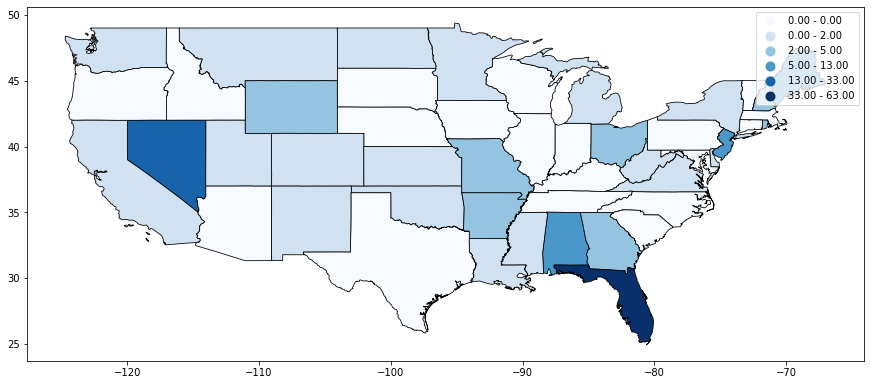

In [321]:
# plot data on map
# rtp.plot(column=var, cmap='Reds', legend=True, linewidth=0.8, ax=ax, edgecolor='0.8')
# rtp.plot(column=var, ax=ax, legend=True, legend_kwds={'label': 'Stroke', 'orientation': "horizontal"})
# rtp.plot(column=var, ax=ax, cmap ='YlGnBu', figsize=(15,9), scheme='quantiles', k=3, legend=True)
ax = rtp.dropna().plot(column=var, cmap =    
                                 'Blues', 
                                 figsize=(15,9),   
                                 scheme='natural_breaks', k=6, 
                                 legend=True,
                                 edgecolor='black', 
                                 linewidth=0.8);

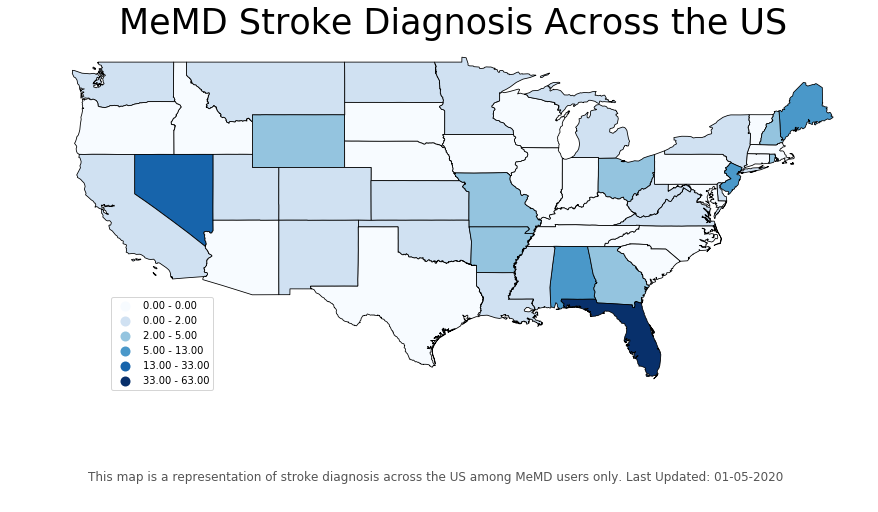

In [322]:
#remove axes
ax.axis('off')

# add title
ax.set_title(f'MeMD {condition.capitalize()} Diagnosis Across the US', fontdict={'fontsize': '35', 'fontweight' : '5'})

# move legend to an empty space (first num moves horizontally second vertically)
ax.get_legend().set_bbox_to_anchor((.22,.29))

#add annotation
current_time = datetime.now()
date = current_time.strftime('%m-%d-%Y')
ax.annotate(f'This map is a representation of {condition} diagnosis across the US among MeMD users only. Last Updated: {date}', xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
ax.get_figure()

In [ ]:
# GET /conditions_map
# $ curl "http://serverIp:8888/conditions_map?condition=<condition>"

print(json.dumps({
  'Does this work?': 'This totally works!'
}))